<a href="https://colab.research.google.com/github/Goldreich/stat_348/blob/main/assignments/hw2/hw2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework 2:** The Hunt for the USS Scorpion (Part II)
## Logistic regression, beta-binomial updating, and empirical Bayes
STATS348, UChicago, Spring 2023

----------------
Or Goldreich

----------------

<a href="https://colab.research.google.com/github/aschein/stat_348/blob/main/assignments/hw2/hw2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---

## Instructions

The purpose of this homework is to apply the concepts raised in [lecture 3](https://github.com/aschein/stat_348/blob/main/materials/3_logreg_and_beta_binomial.pdf):

* logistic regression
* overfitting
* beta-Binomial conjugacy
* empirical Bayes

This homework will also familiarize you with the Python package [scikit-learn](https://scikit-learn.org/stable/).

Assignment is due **Monday April 3, 11:59pm** on Canvas.

## Setting

It is May 1968 and the USS _Scorpion_ has just disappeared somewhere in the Atlantic Ocean, likely off the coast of Spain. You are the lone statistician on board the USS _Mizar_, which has been dispatched to find the missing submarine. Your job is to guide the search as best you can, given the data at your disposal.

## Search effectiveness probability (SEP)
As we saw last week, an important component of our decision problem is the _search effectiveness probability_ of each search cell $k$

\begin{equation}
q_k = P(\textrm{finding the sub in $k$} \mid \textrm{sub is in $k$}, \textrm{divers search $k$})
\end{equation}

There are a number of factors that go into the SEP. The ocean floor is deeper in some cells, the ocean current is stronger, the water is murkier, etc. It's important we understand how easy it would be to actually detect the submarine in each cell before we send divers to look for it.

In this assignment, we will explore two different ways of modeling $q_k$
* Supervised learning, with logistic regression
* Beta-binomial updating, and empirical Bayes

In [2]:
# library for dataframes
import pandas as pd

# scientific computing libraries
import numpy as np
import numpy.random as rn
import scipy.stats as st
import scipy.special as sp
import scipy.optimize as opt

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# progress bars for loops
from tqdm.notebook import tqdm


# Part I: Learning SEPs with logistic regression

## Setting

In this part of the assignment, we will define SEPs across cells to be a function of covariates

\begin{equation}
q_k \triangleq q(\boldsymbol{x}_k)
\end{equation}

where $\boldsymbol{x}_k \in \mathbb{R}^p$ are covariates associated with each search cell that measure aspects which relate to divers' ability to find things (e.g., seafloor depth, strength of current, etc.), and perhaps polynomial expansions and interactions between those base covariates.

In this section, we will work with **binary trial data**. In each of $K=100$ cells, we have dropped one large object and seen whether divers were able to recover it. Define the outcome to be

\begin{align}
y_k &= \begin{cases}
1& \textrm{ if divers recovered the object}\\
0& \textrm{ otherwise}
\end{cases}
\end{align}

We will work with **logistic regression** models that make the following assumption:

\begin{align}
q_k \equiv P(y_k = 1 \mid \boldsymbol{x}_k) = \frac{\exp{\beta_0 + \boldsymbol{\beta}_1^\top \boldsymbol{x}_k}}{1 + \exp{\beta_0 + \boldsymbol{\beta}_1^\top \boldsymbol{x}_k}}
\end{align}

Or, equivalently that
\begin{align}
\log (\tfrac{q_k}{1-q_k}) = \beta_0 + \boldsymbol{\beta}_1^\top \boldsymbol{x}_k
\end{align}



## Read in the trial data
Run the following cell, and explore the trial data.

In [3]:
df_logreg_trials = pd.read_csv('logreg_trial_cells.csv')
df_logreg_trials

,cell_id,seafloor_depth,water_temperature,strength_of_current,seafloor_composition,outcome
0,0,3581.873017,21.006783,moderate,sand,1
1,1,715.353815,11.553155,strong,rock,1
2,2,2805.869109,10.707339,moderate,sand,1
3,3,1154.116879,16.352951,strong,mud,0
4,4,1363.089831,12.815914,moderate,mud,1
...,...,...,...,...,...,...
95,95,2659.833294,13.119218,strong,sand,1
96,96,1032.545545,15.699824,weak,sand,0
97,97,3883.862643,17.163361,moderate,mud,0
98,98,504.397526,10.698066,weak,rock,1


## Learn how to preprocess features with `scikit-learn`

Review the code in following cell carefully where we have provided code that takes a `Pandas` dataframe, and turns it into a `numpy` array corresponding to a scaled (samples $\times$ features)-covariate matrix $X$. 

In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline


def get_preprocessor(continuous_cols, categorical_cols, ordinal_cols, ordinal_categories):
    """ Returns a preprocessor object that can be used in a scikit-learn Pipeline.

    Args:
        continuous_cols (list): list of column names for continuous features
        categorical_cols (list): list of column names for categorical features
        ordinal_cols (list): list of column names for ordinal features
        ordinal_categories (list): list of lists of categories for ordinal features
    
    Returns:
        preprocessor (ColumnTransformer): preprocessor object that can be used in a scikit-learn Pipeline
    """
    continuous_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])
    
    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    
    ordinal_transformer = Pipeline(steps=[
        ('ordinal', OrdinalEncoder(categories=ordinal_categories))
    ])
    
    # Combine transformers into a single ColumnTransformer
    preprocessor = ColumnTransformer(transformers=[
        ('continuous', continuous_transformer, continuous_cols),
        ('categorical', categorical_transformer, categorical_cols),
        ('ordinal', ordinal_transformer, ordinal_cols)
    ])
    
    return preprocessor

continuous_cols = ['seafloor_depth', 'water_temperature']
categorical_cols = ['seafloor_composition']
ordinal_cols = ['strength_of_current']
ordinal_categories = [['weak', 'moderate', 'strong']]

preprocessor = get_preprocessor(continuous_cols, categorical_cols, ordinal_cols, ordinal_categories)

X = preprocessor.fit_transform(df_logreg_trials)

print("Shape of covariate matrix X:", X.shape)

Shape of covariate matrix X: (100, 6)


## Question 1 [Code review, write] (5pts)
1) Explain why the shape of the covariate matrix above is (100, 6). Specifically, what do the 6 features correspond to? 

___
The $100$ rows come from the $100$ datapoints.

The $6$ rows correspond to our post-transformation covariates:

* `seafloor_depth` and `water_temperature` are continuous and remain as-is with one column each.
* `seafloor_composition` is categorical, and is split into one column for each of its three values - mud, rock and sand.
* `strength_of_current` is ordinal. While the values of its entries are changed to reflect an order among them, it still only takes one column.
___

## Learn more about the scikit-learn `Pipeline`

The last cell used the scikit-learn `Pipeline` to define a preprocessor that takes in a dataframe and outputs covariate matrix. In the following cell, we provide code that creates a more sophisticated `Pipeline`, which further accepts a desired degree of polynomial expansion and again outputs a covariate matrix. Study the code carefully.

In [5]:
from sklearn.preprocessing import PolynomialFeatures

def get_pipeline(preprocessor, poly_degree=1):
    """ Returns a scikit-learn Pipeline object consisting of a preprocessor and polynomial feature transformer.
    
    Args:
        preprocessor (ColumnTransformer): preprocessor object that can be used in a scikit-learn Pipeline
        poly_degree (int): degree of polynomial features to generate
    """
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('polynomial', PolynomialFeatures(degree=poly_degree, include_bias=True))
    ])
    return pipeline

pipeline = get_pipeline(preprocessor, poly_degree=2)
X = pipeline.fit_transform(df_logreg_trials)
print(X.shape)

(100, 28)


## Question 2 [Code review, write] (10pts)
1) Explain why the shape of the covariate matrix above is (100, 28). Specifically, what do the 28 features correspond to? In this case, do not list the name of each feature. Instead, provide a concise mathematical description of why there are 28 features.

___

The $28$ features correspond to all sub-quadratic monomials with variables corresponding to the original six.
* There is only one monomial of degree zero.
* Given $n$ variables, we can construct $n$ degree-one monomials.
* Given $n$ variables, we can construct ${n\choose 2}+n=\frac{n\left(n+1\right)}{2}$ degree-two monomials. The first summand comes out of all the ways to choose two distinct variables, while the second covers the option of choosing a quadratic term for one variable.

Putting everything together, we have:
$$1+6+\frac{6\cdot7}{2}=28$$

The desired number of columns.
___

## Learn to use `LogisticRegression` in scikit-learn
Study the following code carefully. At a high-level this code:

* Preprocesses the data into two `numpy` arrays: $\boldsymbol{y}, \boldsymbol{X}$ 
* Defines a scikit-learn `LogisticRegression` model with no regularization
* Fits the model to the data and computes the training **accuracy** and **negative log loss**
* Defines a scikit-learn `KFold` object for cross-validation
* Computes the average cross validation accuracy and negative log loss across the K folds

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import KFold, cross_val_score

# binary outcomes
y = df_logreg_trials['outcome'].values

# degree-5 polynomial features
degree = 5
pipeline = get_pipeline(preprocessor, poly_degree=degree)
X = pipeline.fit_transform(df_logreg_trials)

# define logreg model with no regularization, saga solver, and 10,000 iterations
logreg = LogisticRegression(penalty='none', solver='saga', max_iter=10000)

# fit model to data
logreg.fit(X, y)

# calculate accuracy on training data
y_pred = logreg.predict(X)
train_accuracy = accuracy_score(y, y_pred)

# calculate negative log loss on training data
y_prob = logreg.predict_proba(X)
train_neg_log_loss = -log_loss(y, y_prob)

print('Training accuracy: {:.2f}'.format(train_accuracy))
print('Training negative log loss: {:.2f}'.format(train_neg_log_loss))

# define k-fold cross-validation
kfold = KFold(n_splits=10, shuffle=True)

# calculate average cross-validation accuracy across K folds
avg_kfold_accuracy = cross_val_score(logreg, X, y, cv=kfold, scoring='accuracy', n_jobs=-1).mean()
print('Average k-fold accuracy: {:.2f}'.format(avg_kfold_accuracy))

# calculate average cross-validation negative log loss across K folds
avg_kfold_neg_log_loss = cross_val_score(logreg, X, y, cv=kfold, scoring='neg_log_loss', n_jobs=-1).mean()
print('Average k-fold negative log loss: {:.2f}'.format(avg_kfold_neg_log_loss))


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


Training accuracy: 0.97
Training negative log loss: -0.14
Average k-fold accuracy: 0.46
Average k-fold negative log loss: -2.87


## Question 3 [Code review, write, math] (10pts)
1) Explain why there might be a difference between the training versus cross validation accuracy (or negative log loss).

___

Your answer here:

___

2) Write in mathematical form exactly what `-log_loss(y, y_prob)` computes. Your equation should be in terms of the SEPs $q_k$.
___

This is:
$$\sum_{k=1}^K\left(y_k\log\left(\widehat{q_k}\right)+\left(1-y_k\right)\log\left(1-\widehat{q_k}\right)\right)$$

___

## Question 4 [Code] (10pts)

Using what you have learned about how to preprocess data, fit a log-reg model, and use K-fold cross validation...

1) Write code in the following cell that loops through polynomial degrees 1...5, and for each:
    * Prepocesses the data using polynomial feature expansions of the given degree
    * Fits a single unregularized logistic regression model
    * Calculates and saves its training accuracy and negative log loss
    * Creates a K-fold cross validation object
    * Calculates and saves the average cross-validation accuracy and negative log loss across K folds

 
2) Plot the results
    * A plot depicting training versus average cross-validation **accuracy (y-axis)** as a function of **polynomial degree (x-axis)**
    * A plot depicting training versus average cross-validation **negative log loss (y-axis)** as a function of **polynomial degree (x-axis)**




  0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:1173: F

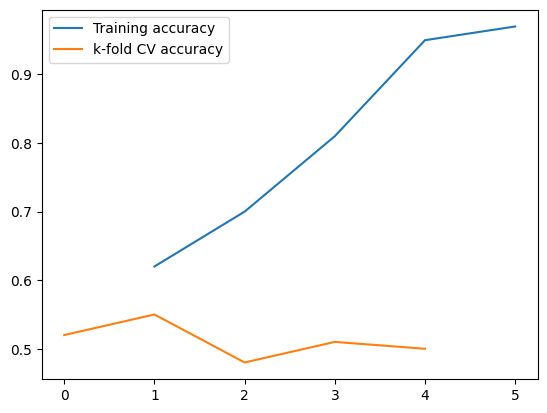

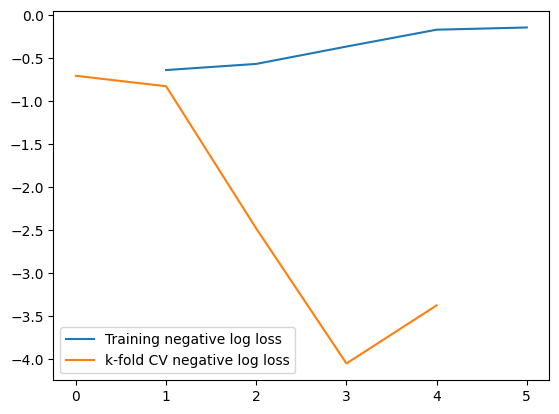

In [7]:
# define the range of polynomial degrees to test
degrees = list(range(1, 6))

# creating variables to store information
train_accs = np.zeros(5)
train_neg_log_losses = np.zeros(5)
avg_kfold_accs = np.zeros(5)
avg_kfold_neg_log_losses = np.zeros(5)

# iterate through each degree, preprocess X, fit model and K-fold CV, calculate training vs kfold accuracy and neg_log_loss
for degree in tqdm(degrees):
    pipeline = get_pipeline(preprocessor, poly_degree=degree)
    X = pipeline.fit_transform(df_logreg_trials)

    logreg = LogisticRegression(penalty='none', solver='saga', max_iter=10000)
    logreg.fit(X, y)

    y_pred = logreg.predict(X)
    train_accs[degree-1] = accuracy_score(y, y_pred)

    y_prob = logreg.predict_proba(X)
    train_neg_log_losses[degree-1] = -log_loss(y, y_prob)

    kfold = KFold(n_splits=10, shuffle=True)
    avg_kfold_accs[degree-1] = cross_val_score(logreg, X, y, cv=kfold, scoring='accuracy', n_jobs=-1).mean()
    avg_kfold_neg_log_losses[degree-1] = cross_val_score(logreg, X, y, cv=kfold, scoring='neg_log_loss', n_jobs=-1).mean()

# Plot the results: training versus k-fold CV accuracy (y-axis) as a function of degree (x-axis)
plt.figure(1)
plt.plot(degrees, train_accs, avg_kfold_accs)
plt.legend(('Training accuracy', 'k-fold CV accuracy'), loc='best')

# Plot the results: training versus k-fold CV negative log-loss (y-axis) as a function of degree (x-axis)
plt.figure(2)
plt.plot(degrees, train_neg_log_losses, avg_kfold_neg_log_losses)
plt.legend(('Training negative log loss', 'k-fold CV negative log loss'), loc='best')

## Question 5 [Write] (5pts)
Reflect on the above plots you have generated. What are some conclusions you might draw from them?

___

As we increase the degree, the training accuracy and log loss improve, which is to be expected as adding covariates always reduces a GLM's lest squares error, regardless of whether the added covariates hold any real world meaning.

In contrast, the opposite happens for k-fold cross-validation, with the exception of an uptick for the negative log loss at degree $5$. This suggests that the CV accuracy and negative log loss might be more sensitive to the addition of superfluous covariates to the model.

___

## Learn to use `GridSearchCV`
In the following cell, we have provided code that uses `GridSearchCV` to perform a grid search over the best-performing combination of 
* polynomial degree (`degree` = [1...5]) $\times$
* regularization type (`l1` versus `l2`) $\times$
* regularization strength (`C`=[0.1...5])

The code finds the logreg model with the lowest cross-validation log loss.

In [8]:
from sklearn.model_selection import GridSearchCV

# Create a pipeline for the whole process
pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('polynomial', PolynomialFeatures(include_bias=True)),
        ('classifier', LogisticRegression(solver='saga', max_iter=10000))
    ])

# Define the parameter grid for GridSearchCV
param_grid = {
    'polynomial__degree': [1, 2, 3, 4, 5],
    'classifier__C': [0.1, 0.25, 0.5, 0.75, 1, 2, 5],
    'classifier__penalty': ['l1', 'l2']
}

# Use GridSearchCV to find the best combination of parameters and fit the data
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_log_loss', refit=True)
grid_search.fit(df_logreg_trials, y)

# Print the best parameters and score
print("Best parameters found: ", grid_search.best_params_)
print("Best CV negative log loss: ", grid_search.best_score_)

# Save the best model as best_model
best_model = grid_search.best_estimator_

Best parameters found:  {'classifier__C': 0.25, 'classifier__penalty': 'l1', 'polynomial__degree': 3}
Best CV negative log loss:  -0.6310067703593079


## Question 6 [Code] (10pts)
In this question, you will use the results of grid search above. In the cell below, write code that:

1) Uses the best-performing model to calculate the SEPs for all trial cells.

2) Plots a histogram of the estimated SEPs.

(array([ 4.,  2., 10., 29., 17., 14.,  3.,  7.,  6.,  8.]),
 array([0.16508686, 0.24236572, 0.31964459, 0.39692345, 0.47420232,
        0.55148118, 0.62876004, 0.70603891, 0.78331777, 0.86059664,
        0.9378755 ]),
 <BarContainer object of 10 artists>)

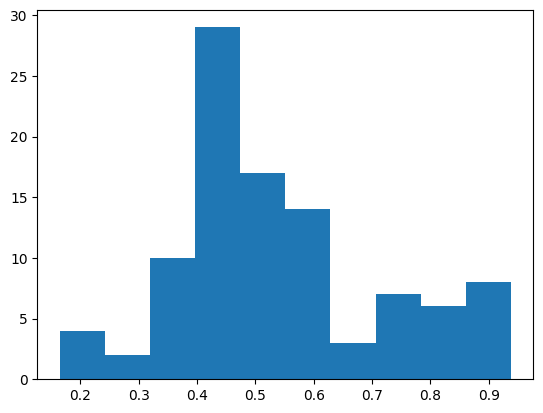

In [9]:
# Use the best CV model to calculate the SEPs for all trial cells

seps = best_model.predict_proba(df_logreg_trials)[:,0]

# Plot a histogram of the SEPS

plt.hist(seps)

# Part II: Beta-binomial updating and empirical Bayes

In this second part, we will approach the problem differently. Instead of using covariates to share information across cells, we will assume that all SEPs come from a **shared prior distribution** $q_k \stackrel{\textrm{iid}}{\sim}P(q)$. 

This part also incorporates the possibility of multiple trials $N_k$ per cell. The outcome data is now
\begin{align}
y_k &\in \{0,\dots, N_k\}&\textrm{ the number of successful trials}
\end{align}

We will assume the following beta-binomial model:

\begin{align}
q_k &\stackrel{\textrm{iid}}{\sim} \textrm{Beta}(a_0,\,b_0) \\
y_k &\stackrel{\textrm{ind.}}{\sim} \textrm{Binom}(N_k,\, q_k)
\end{align}

In this model, we assume the SEPs $q_k$ across all cells $k$ were drawn from a shared beta distribution with shape parameters $a_0$ and $b_0$. The number of successes $y_k$ conditioned on the number of trials $N_k$ and $q_k$ is then binomially-distributed.

Put another way, this implies the following **marginal likelihood** for the trial data:

\begin{align}
P(\boldsymbol{y}_{1:K} \mid \boldsymbol{N}_{1:K}, a_0,\,b_0\,) &= \prod_{k=1}^K P(y_k \mid N_k, a_0,\,b_0\,) \\
&= \prod_{k=1}^K \int \underbrace{P(y_k \mid N_k,\, q_k)}_{\textrm{Binom}(y_k; N_k\,q_k)} \, \underbrace{P(q_k \mid a_0,\, b_0)}_{\textrm{Beta}(q_k;a_0,\,b_0)}\,dq_k
\end{align}

## Question 7 [Math] (10pts)
1) Provide an analytic expression (i.e., without any integrals) for the negative log marginal likelihood:
\begin{equation}
-\log P(\boldsymbol{y}_{1:K} \mid \boldsymbol{N}_{1:K}, a_0,\,b_0\,) = -\sum_{k=1}^K\log\int P\left(y_k\mid N_k,q_k\right)P\left(q_k\mid a_0,b_0\right)dq_k\\= -\sum_{k=1}^K\log\int {N_k\choose y_k}q_k^{y_k}\left(1-q_k\right)^{N_k-y_k}\frac{\Gamma\left(a_0+b_0\right)}{\Gamma\left(a_0\right)\Gamma\left(b_0\right)}q_k^{a_0-1}\left(1-q_k\right)^{b_0-1}dq_k\\=-\sum_{k=1}^K\log\left[{N_k\choose y_k}\frac{\Gamma\left(a_0+b_0\right)}{\Gamma\left(a_0\right)\Gamma\left(b_0\right)}\frac{\Gamma\left(y_k+a_0\right)\Gamma\left(N_k-y_k+b_0\right)}{\Gamma\left(N_k+a_0+b_0\right)}\underbrace{\int\frac{\Gamma\left(N_k+a_0+b_0\right)}{\Gamma\left(y_k+a_0\right)\Gamma\left(N_k-y_k+b_0\right)}q_k^{y_k+a_0-1}\left(1-q_k\right)^{N_k-y_k+b_0-1}dq_k}_{=1\text{ as the density integral of Beta}\left(y_k+a_0,N_k-y_k+b_0\right)}\right]\\
=K\log\left(\frac{\Gamma\left(a_0\right)\Gamma\left(b_0\right)}{\Gamma\left(a_0+b_0\right)}\right)-\sum_{k=1}^K\left[\log\left({N_k\choose y_k}\right)+\log\left(\frac{\Gamma\left(y_k+a_0\right)\Gamma\left(N_k-y_k+b_0\right)}{\Gamma\left(N_k+a_0+b_0\right)}\right)\right]
\end{equation}

2) Briefly explain how you came to this expression.

___

Direct computation.

___

## Question 8 [Code] (15pts)

In this question, you will learn to use `scipy.optimize.minimize` to minimize a custom function. Make sure to read the [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) and to experiment with different settings.

Write the following code in the cell below:

1) Implement a function to compute the negative log marginal likelihood. Your function can use **any** functions available in the `numpy` or `scipy` Python libraries.


2) Implement a function that estimates the parameters $a_0, b_0$ using type-II maximum likelihood by minimizing your function `neg_log_marginal_likelihood` using `scipy.optimize.minimize`

In [10]:
from scipy.optimize import minimize

def neg_log_marginal_likelihood(params, y, n):
    """ Calculate the negative log-marginal likelihood for the beta-binomial model.
    
    Args:
        params (tuple): the parameters of the marginal likelihood (a0, b0)
        y (array): the number of successes for each trial
        n (array): the number of trials
    
    Returns:
        float: the negative log-marginal likelihood
    """
    a0, b0 = params

    # Your code here

    neg_log_marginal_likelihood = -st.betabinom.logpmf(y, n, a0, b0).sum()

    return neg_log_marginal_likelihood

def fit_marginal_likelihood(y, n):
    """ Fit the parameters of the marginal likelihood to the data using maximum likelihood.

    Uses scipy.optimize.minimize and calls neg_log_marginal_likelihood.

    Args:
        y (array): the number of successes for each trial
        n (array): the number of trials
        
        If you add other args, describe them here.
    
    Returns:
        tuple: the MLE for a0 and b0
    """
    
    # Your code here
    a0_mle, b0_mle = opt.minimize(neg_log_marginal_likelihood, x0=(1, 1), args=(y, n)).x

    return a0_mle, b0_mle

## Run your code on the trial data

Run the following code, which:
1) Loads the trial data. Note that this time, we have multiple trials per cell $N_k$ (`n_trials`) and potentially multiple successes per cell $y_k$ (`n_successes`)

2) Runs your `fit_marginal_likelihood` function on the data. Make sure to modify this line if your function takes additional arguments

3) Plots the estimated **empirical prior**.


3.7857743261144 4.604624496958918


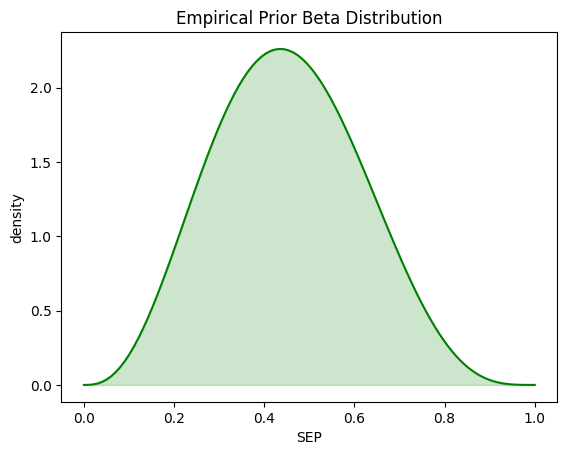

In [ ]:
# load in the beta-binomial trial data
df_trials = pd.read_csv('betabin_trial_cells.csv')
y = df_trials['n_successes'].values
n = df_trials['n_trials'].values

# if your fit_marginal_likelihood function takes extra args, modify this code to pass them in here.
a0_mle, b0_mle = fit_marginal_likelihood(y, n)
print(a0_mle, b0_mle)

# plot the empirical prior beta distribution
x_axis_vals = np.linspace(0, 1, 100)
y_axis_vals = st.beta.pdf(x_axis_vals, a0_mle, b0_mle)
_ = plt.plot(x_axis_vals, y_axis_vals, color='Green')
_ = plt.fill_between(x_axis_vals, y_axis_vals, alpha=0.2, color='Green')
_ = plt.title('Empirical Prior Beta Distribution')
_ = plt.xlabel('SEP')
_ = plt.ylabel('density')

## Question 9 [Math] (10pts)

1) Provide the form of the posterior over cell $k$'s SEP $q_k$, conditioned on the number of trials $N_k$ and successes $y_k$ in the cell, and the estimated parameters $\hat{a_0}$, $\hat{b_0}$:
\begin{equation}
P(q_k \mid y_k,\, N_k,\,\hat{a_0}, \hat{b_0}) = \textrm{Your answer here}
\end{equation}

2) Provide the form of the posterior expectation
\begin{equation}
E[q_k \mid y_k,\, N_k,\,\hat{a_0}, \hat{b_0}] = \textrm{Your answer here}
\end{equation}

## Question 10 [Code] (5pts)
1) Implement a function to compute the posterior expectation above.

2) Compute the posterior expectation of $q_k$ for all trial cells.

3) Plot a histogram of the estimated SEPs. (Run the code)

In [ ]:
def posterior_expectation(y, n, a0, b0):
    """ Calculate the posterior expectation of SEP.

    Args:
        y (array): the number of successes for each trial
        n (array): the number of trials
        a0 (float): the prior alpha parameter
        b0 (float): the prior beta parameter
    
    Returns:
        array: the posterior expectation of SEP
    """
    # Your code here

    return estimated_SEP

estimated_SEP = posterior_expectation(y, n, a0_mle, b0_mle)
_ = plt.hist(estimated_SEP)

## Question [Write] (10pts) 

1) Reflect on the pros and cons of the two approaches we used to estimate SEPs (supervised learning and posterior updating). Under what conditions might we  prefer one over the other?

___

Your answer here:

___

2) Reflect on how we might combine these approaches. Describe a third approach that would combine elements of both:

___

Your answer here:

___
